In [143]:
!pip install pandas
!pip install matplotlib

In [144]:
import pandas as pd
import matplotlib.pyplot as plt
# 定義進程類
class Process:
    def __init__(self, pid, arrival_time, burst_time, priority=0):
        self.pid = pid
        self.arrival_time = arrival_time
        self.burst_time = burst_time
        self.remaining_time = burst_time
        self.priority = priority
        self.start_time = -1
        self.finish_time = 0
        self.wait_time = 0

In [145]:
# Shortest Remaining Time First (SRTF)
def srtf(processes):
    time = 0  # 當前時間（模擬調度時鐘）
    complete = 0  # 完成的進程數量
    n = len(processes)  # 進程的總數
    processes.sort(key=lambda x: (x.arrival_time, x.burst_time))  # 按到達時間和執行時間對進程進行排序
    timeline = []  # 用於記錄甘特圖的時間軸，包含 (當前時間, 進程 ID)

    while complete != n:  # 當所有進程都完成時退出循環
        shortest = None  # 儲存當前剩餘執行時間最短的進程
        for proc in processes:  # 遍歷所有進程，尋找合適的進程
            # 條件1：進程已到達（arrival_time <= 當前時間）
            # 條件2：進程仍有剩餘執行時間（remaining_time > 0）
            if proc.arrival_time <= time and proc.remaining_time > 0:
                # 如果目前尚未選擇進程或找到更短的剩餘執行時間進程，更新 shortest
                if shortest is None or proc.remaining_time < shortest.remaining_time:
                    shortest = proc

        if shortest is None:  # 如果沒有符合條件的進程
            time += 1  # 時鐘前進一個單位時間
            continue  # 回到循環開頭

        # 如果該進程尚未開始執行，記錄其開始時間
        if shortest.start_time == -1:
            shortest.start_time = time

        # 記錄該進程在當前時間被執行（甘特圖時間軸）
        timeline.append((time, shortest.pid))

        # 執行進程一個時間單位，剩餘執行時間減少
        shortest.remaining_time -= 1
        time += 1  # 時鐘前進一個單位時間

        # 如果進程執行完畢（剩餘執行時間為0）
        if shortest.remaining_time == 0:
            complete += 1  # 更新完成的進程數量
            shortest.finish_time = time  # 設定該進程的完成時間
            # 計算等待時間 = 完成時間 - 執行時間 - 到達時間
            shortest.wait_time = shortest.finish_time - shortest.burst_time - shortest.arrival_time

    return timeline  # 返回甘特圖的時間軸，供繪製用


In [146]:
def priority_scheduling(processes):
    time = 0  # 初始化時間為0
    complete = 0  # 初始化已完成進程計數器為0
    n = len(processes)  # 獲取進程數量

    # 根據抵達時間和優先級對進程進行排序，首先考慮先抵達者，再考慮優先級較高者（數字較小）
    processes.sort(key=lambda x: (x.arrival_time, x.priority))
    
    # 用於記錄甘特圖的時間軸，顯示每一時間單位哪個進程在運行
    timeline = []

    while complete != n:  # 當所有進程都完成時停止迴圈
        highest_priority = None  # 儲存當前時間下優先級最高的進程

        for proc in processes:  # 遍歷每個進程
            if proc.arrival_time <= time and proc.remaining_time > 0:
                # 進程已經抵達且尚未完成
                if highest_priority is None or proc.priority < highest_priority.priority:
                    # 如果還未選定進程或找到更高優先級（數字較小）的進程
                    highest_priority = proc  # 更新為當前最高優先級的進程

        if highest_priority is None:
            # 如果在當前時間沒有進程可被選擇
            time += 1  # 將時間推進1單位
            continue  # 繼續下一次操作

        if highest_priority.start_time == -1:
            # 如果這是該進程首次執行
            highest_priority.start_time = time
            # 設定其開始時間
        
        for t in range(highest_priority.remaining_time):
            timeline.append((time + t, highest_priority.pid))
            # 記錄該進程在甘特圖中的每一時間單位下的進程 ID

        time += highest_priority.remaining_time
        # 將時間推前至該最高優先級進程執行完成時

        highest_priority.finish_time = time
        # 設定該進程的完成時間

        highest_priority.wait_time = (highest_priority.finish_time
                                      - highest_priority.burst_time
                                      - highest_priority.arrival_time)
        # 計算該進程的等待時間：完成時間 - 執行時間 - 抵達時間

        highest_priority.remaining_time = 0
        # 標記該進程的剩餘時間為0（已完成）

        complete += 1  # 增加完成進程的計數

    return timeline  # 返回甘特圖的時間軸

In [147]:
def round_robin(processes, quantum):
    time = 0  # 初始化時間為0
    queue = []  # 初始化就緒隊列以儲存待執行的進程
    timeline = []  # 用於記錄甘特圖的時間軸，顯示每一時間單位哪個進程在運行

    for proc in processes:
        # 初始化進程的開始時間為-1，表示尚未開始執行
        proc.start_time = -1

    # 持續運行直到所有進程的剩餘時間均等於0
    while any(proc.remaining_time > 0 for proc in processes):
        # 將抵達且尚未完成的進程加入隊列
        for proc in processes:
            if proc.arrival_time <= time and proc.remaining_time > 0 and proc not in queue:
                queue.append(proc)

        if not queue:
            # 如果隊列中沒有進程可以執行，時間推進1單位
            time += 1
            continue

        # 從隊列中取出第一個進程進行執行
        proc = queue.pop(0)

        if proc.start_time == -1:
            # 如果這是進程首次執行，設定其開始時間
            proc.start_time = time

        # 設定實際執行時間為進程剩餘時間與時間片大小的最小值
        executed_time = min(proc.remaining_time, quantum)

        # 記錄該進程在甘特圖的每一單位時間下的進程 ID
        for t in range(executed_time):
            timeline.append((time + t, proc.pid))

        # 減少進程的剩餘執行時間
        proc.remaining_time -= executed_time

        # 將時間推進實際執行時間
        time += executed_time

        if proc.remaining_time > 0:
            # 如果進程尚未完成，再次加入隊列以備下次執行
            queue.append(proc)
        else:
            # 如果進程執行完成，設定其完成時間
            proc.finish_time = time

        # 計算進程的等待時間
        proc.wait_time = proc.finish_time - proc.burst_time - proc.arrival_time

    return timeline  # 返回甘特圖的時間軸

In [148]:
# 計算效能指標的函數
def calculate_metrics_with_variance(processes):
    # 獲取進程的數量
    n = len(processes)

    # 提取所有進程的等待時間
    waiting_times = [proc.wait_time for proc in processes]

    # 計算所有進程的周轉時間（完成時間 - 到達時間）
    turnaround_times = [proc.finish_time - proc.arrival_time for proc in processes]

    # 計算平均等待時間
    avg_waiting_time = sum(waiting_times) / n

    # 計算平均周轉時間
    avg_turnaround_time = sum(turnaround_times) / n

    # 計算總回應時間（每個進程的開始時間 - 到達時間）
    total_response_time = sum(proc.start_time - proc.arrival_time for proc in processes)

    # 計算通過率（進程數量 / 最大完成時間）
    throughput = n / max(proc.finish_time for proc in processes)

    # 計算 CPU 使用率（所有進程的執行時間總和 / 最大完成時間）
    cpu_utilization = sum(proc.burst_time for proc in processes) / max(proc.finish_time for proc in processes)

    # 返回計算結果的字典，包含所有效能指標
    return {
        "Avg Waiting Time": avg_waiting_time,  # 平均等待時間
        "Avg Turnaround Time": avg_turnaround_time,  # 平均周轉時間
        "Response Time": total_response_time / n,  # 平均回應時間
        "Throughput": throughput,  # 通過率
        "CPU Utilization": cpu_utilization  # CPU 使用率
    }

In [149]:
# 繪製甘特圖的函數
def generate_gantt_chart(timeline, algorithm_name):
    # 將時間軸和進程 ID 整理成 DataFrame
    df = pd.DataFrame(timeline, columns=['Time', 'Process ID'])

    # 按照進程 ID 分組，並將每個進程的時間收集成列表
    df_grouped = df.groupby('Process ID')['Time'].apply(list).to_dict()

    # 創建一個圖形和坐標軸以進行繪圖
    fig, ax = plt.subplots(figsize=(10, 6))

    # 遍歷每個進程及其對應的時間
    for pid, times in df_grouped.items():
        start = times[0]  # 獲取該進程的開始時間
        duration = 1  # 初始化持續時間

        # 遍歷時間列表，計算持續時間
        for i in range(1, len(times)):
            # 如果當前時間與前一個時間相連，增加持續時間
            if times[i] == times[i - 1] + 1:
                duration += 1
            else:
                # 當不連續時，繪製剛才計算的段落
                ax.broken_barh([(start, duration)], (pid - 0.4, 0.8), facecolors='blue')
                
                # 更新開始時間與持續時間
                start = times[i]
                duration = 1
        
        # 繪製最後一段持續時間
        ax.broken_barh([(start, duration)], (pid - 0.4, 0.8), facecolors='blue')

    # 設置 x 軸標籤
    ax.set_xlabel('Time')
    # 設置 y 軸標籤
    ax.set_ylabel('Process ID')
    # 設置圖表標題
    ax.set_title(f"Gantt Chart for {algorithm_name}")
    
    # 顯示繪製的甘特圖
    plt.show()

In [150]:
# 比較調度算法並生成比較圖表
def compare_scheduling_algorithms(processes, maxbursttime):
    results = {}

    # 複製原始進程資料
    processes_srtf = [Process(p.pid, p.arrival_time, p.burst_time) for p in processes]
    processes_priority = [Process(p.pid, p.arrival_time, p.burst_time, p.priority) for p in processes]
    processes_rr = [Process(p.pid, p.arrival_time, p.burst_time) for p in processes]

    # 執行 SRTF
    srtf_timeline = srtf(processes_srtf)
    results["SRTF"] = calculate_metrics_with_variance(processes_srtf)
    generate_gantt_chart(srtf_timeline, "SRTF")

    # 執行 Priority Scheduling
    priority_timeline = priority_scheduling(processes_priority)
    results["Priority"] = calculate_metrics_with_variance(processes_priority)
    generate_gantt_chart(priority_timeline, "Priority Scheduling")

    # 執行 Round Robin
    for i in range(1,maxbursttime+1):
        processes_rr_i = [Process(p.pid, p.arrival_time, p.burst_time) for p in processes]
        rr_timeline = round_robin(processes_rr_i, i)
        results[f"RR_Q = {i}"] = calculate_metrics_with_variance(processes_rr_i)
        generate_gantt_chart(rr_timeline, f"RR_Q = {i}")
    
    # 繪製在不同 Quantum 下的 Response Time、Turnaround Time、Waiting Time 的點線圖
    quantum_values = range(1, maxbursttime + 1)
    response_times = [results[f"RR_Q = {q}"]['Response Time'] for q in quantum_values]
    turnaround_times = [results[f"RR_Q = {q}"]['Avg Turnaround Time'] for q in quantum_values]
    waiting_times = [results[f"RR_Q = {q}"]['Avg Waiting Time'] for q in quantum_values]

    plt.figure(figsize=(12, 8))
    plt.plot(quantum_values, response_times, marker='o', label='Response Time')
    plt.plot(quantum_values, turnaround_times, marker='o', label='Turnaround Time')
    plt.plot(quantum_values, waiting_times, marker='o', label='Waiting Time')
    plt.xlabel('Quantum')
    plt.ylabel('Time')
    plt.title('Response Time, Turnaround Time, and Waiting Time vs Quantum')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 結果匯總與圖表繪製
    metrics_df = pd.DataFrame(results).T
    metrics_df.plot(kind='bar', figsize=(12, 8))
    plt.title('Comparison of Scheduling Algorithms')
    plt.ylabel('Metrics')
    plt.xticks(rotation=45)
    plt.legend(loc='best')
    plt.grid(axis='y')
    plt.show()

    # 繪製等待時間、周轉時間和回應時間的圖表
    fig, axes = plt.subplots(3, 1, figsize=(12, 18))

    metrics_df[['Avg Waiting Time']].plot(kind='bar', ax=axes[0], legend=False)
    axes[0].set_title('Average Waiting Time')
    axes[0].set_ylabel('Time')
    axes[0].set_xticklabels(metrics_df.index, rotation=30)

    metrics_df[['Avg Turnaround Time']].plot(kind='bar', ax=axes[1], legend=False)
    axes[1].set_title('Average Turnaround Time')
    axes[1].set_ylabel('Time')
    axes[1].set_xticklabels(metrics_df.index, rotation=30)

    metrics_df[['Response Time']].plot(kind='bar', ax=axes[2], legend=False)
    axes[2].set_title('Response Time')
    axes[2].set_ylabel('Time')
    axes[2].set_xticklabels(metrics_df.index, rotation=30)

    plt.tight_layout()
    plt.show()

    return metrics_df

In [151]:
import random
# 隨機生成測試進程
def generate_random_processes(num_processes, max_arrival_time, max_burst_time, max_priority):
    return [
        Process(
            pid=i + 1,
            arrival_time=random.randint(0, max_arrival_time),
            burst_time=random.randint(1, max_burst_time),
            priority=random.randint(1, max_priority)
        )
        for i in range(num_processes)
    ]

Process 1: Arrival Time=11, Burst Time=20, Priority=2
Process 2: Arrival Time=0, Burst Time=10, Priority=6
Process 3: Arrival Time=16, Burst Time=1, Priority=5
Process 4: Arrival Time=8, Burst Time=13, Priority=5
Process 5: Arrival Time=15, Burst Time=7, Priority=10
Process 6: Arrival Time=20, Burst Time=4, Priority=6
Process 7: Arrival Time=20, Burst Time=2, Priority=9
Process 8: Arrival Time=1, Burst Time=15, Priority=3
Process 9: Arrival Time=5, Burst Time=10, Priority=8
Process 10: Arrival Time=20, Burst Time=17, Priority=2


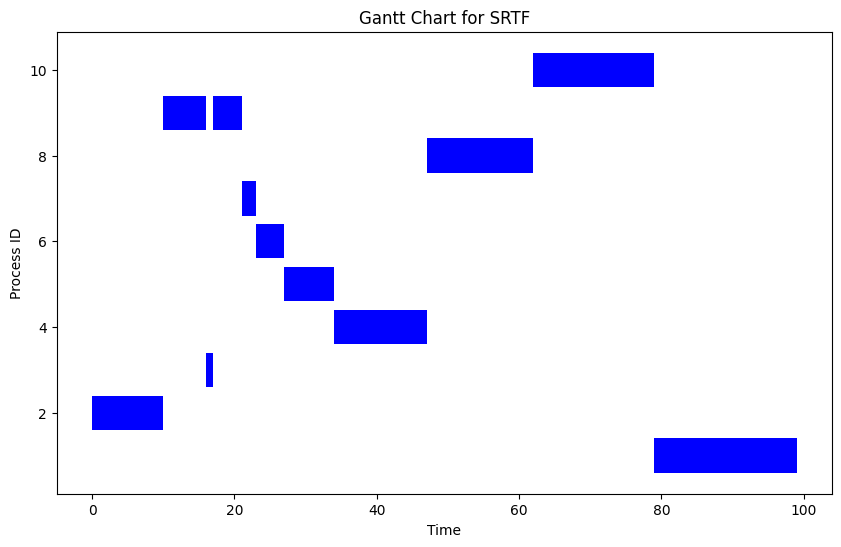

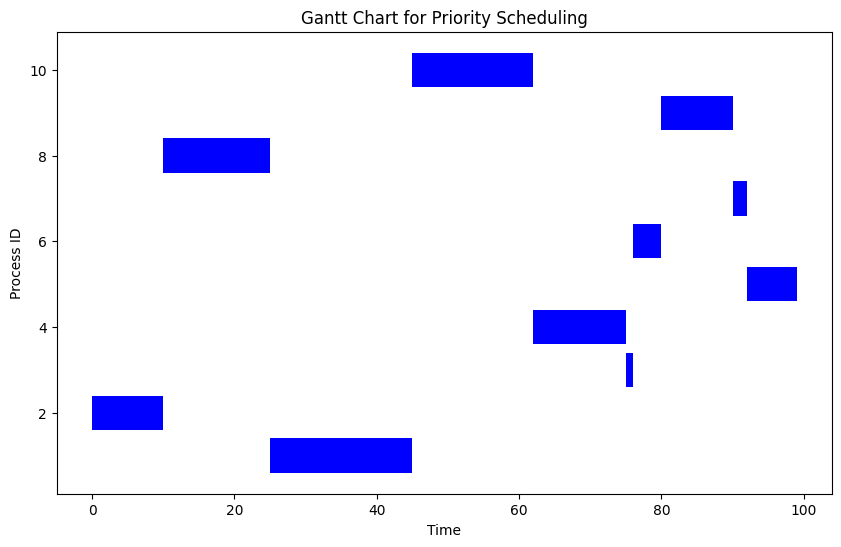

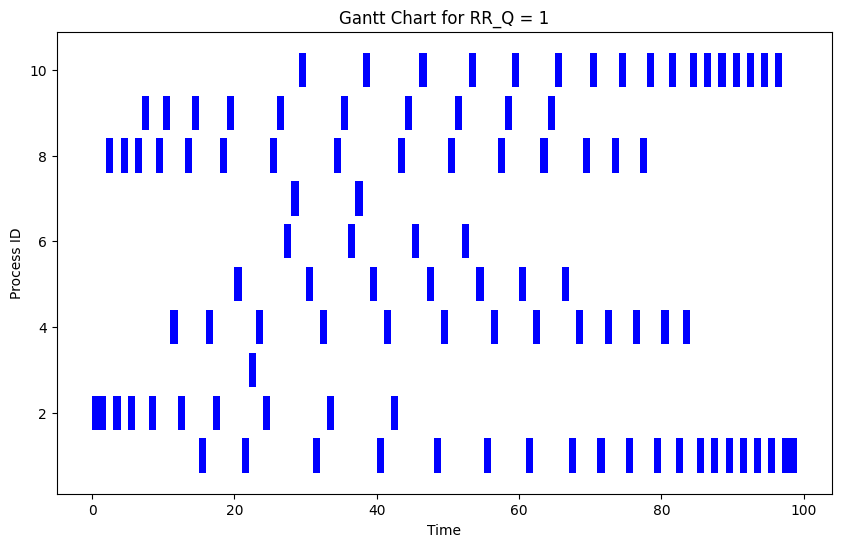

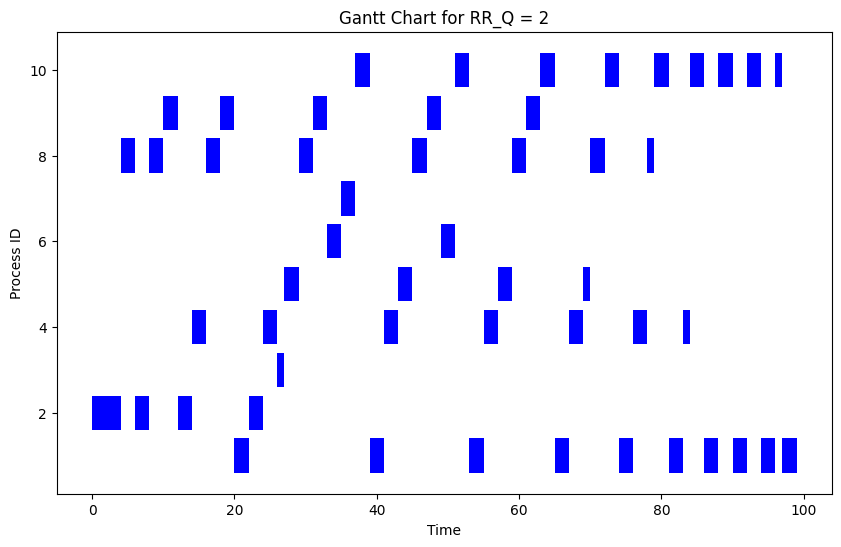

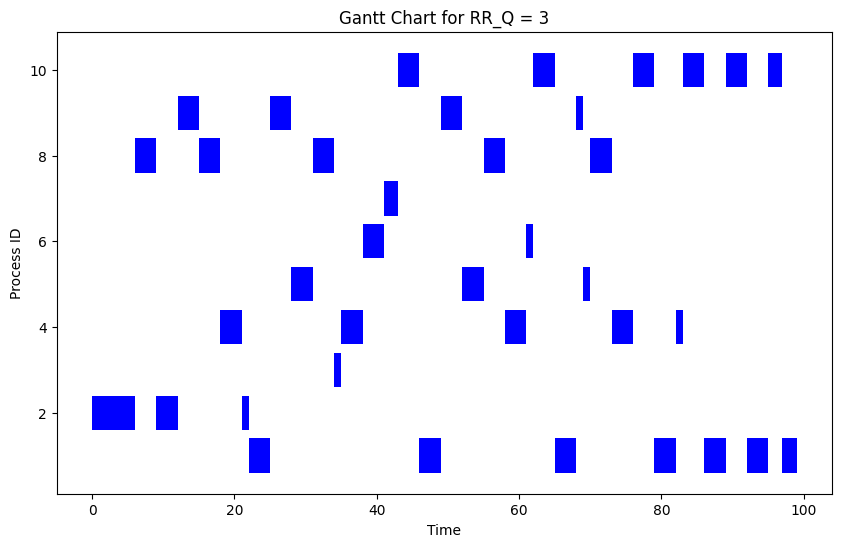

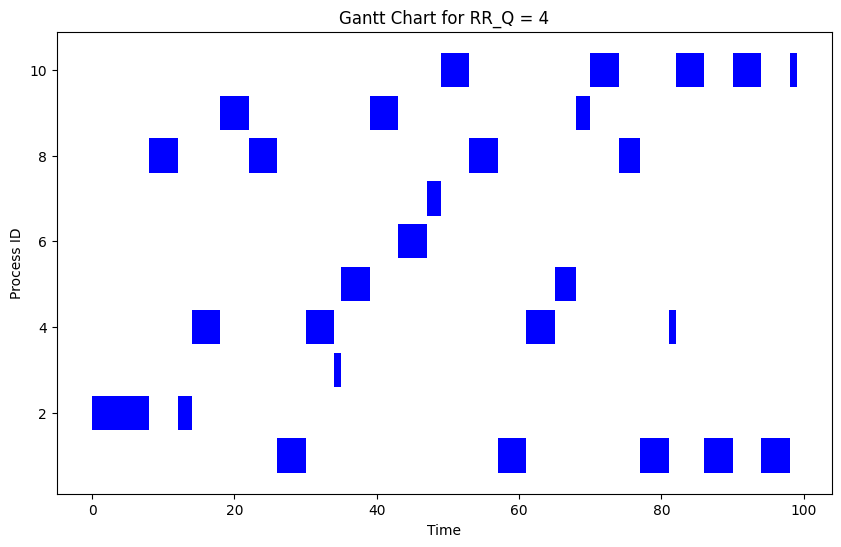

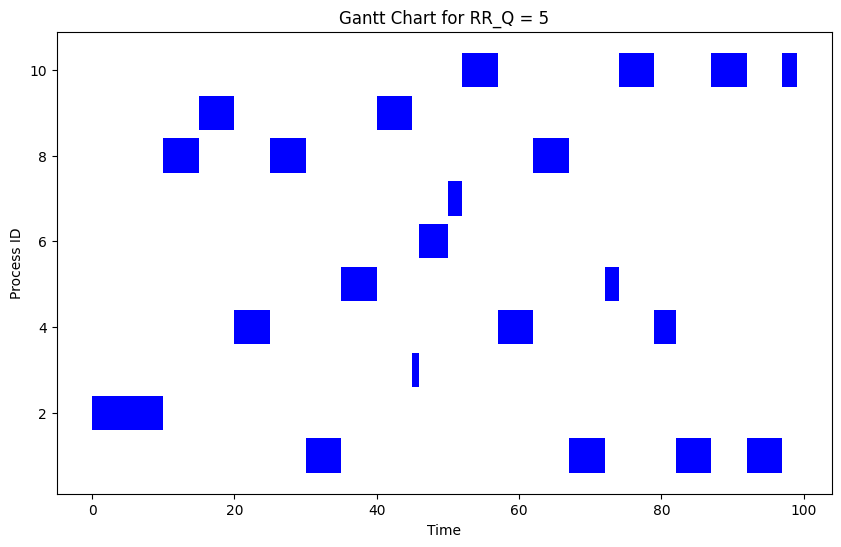

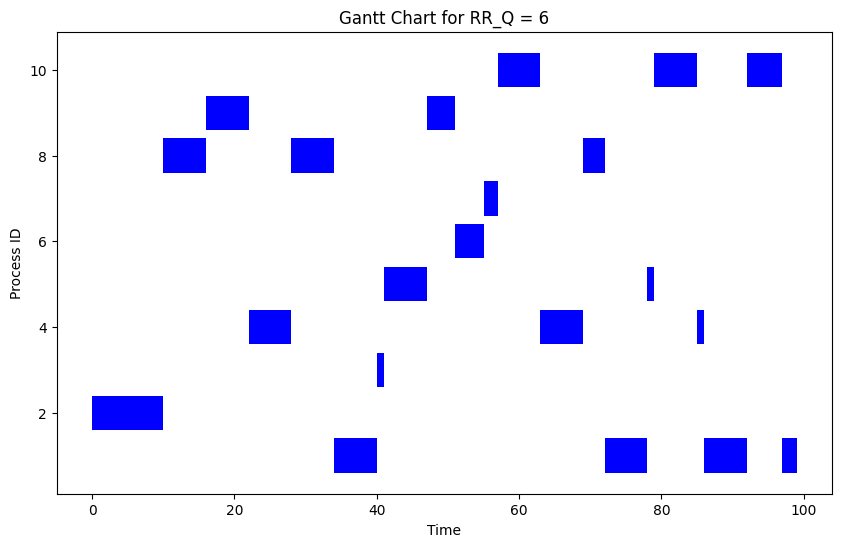

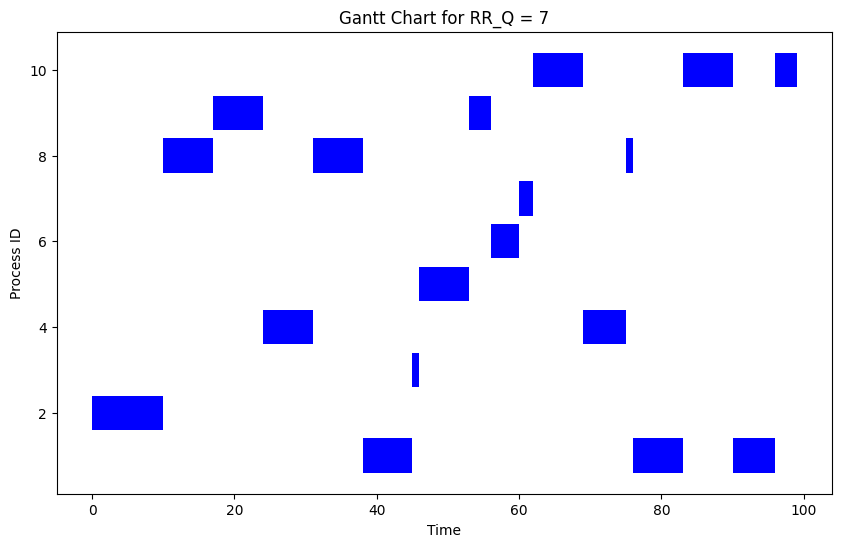

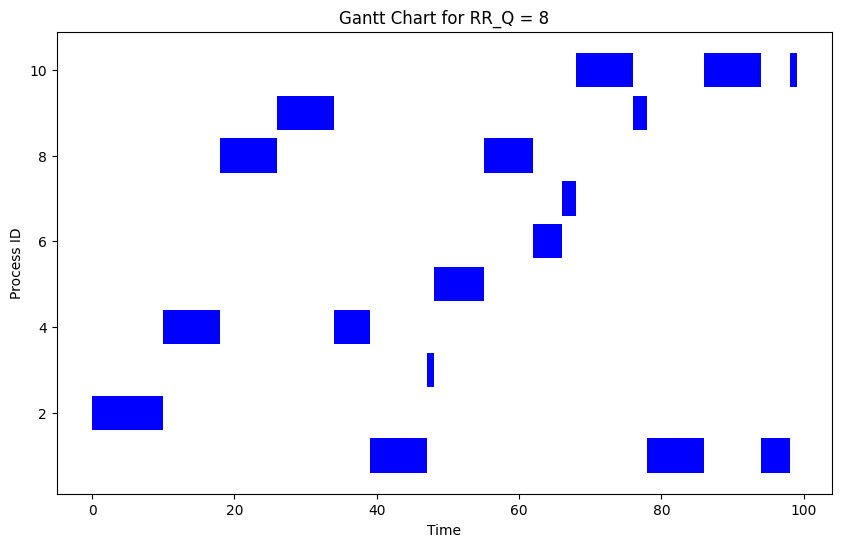

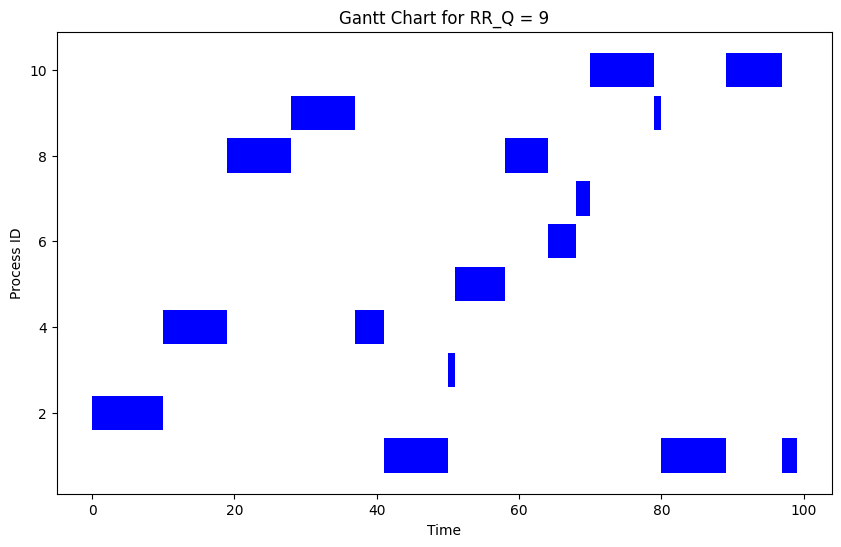

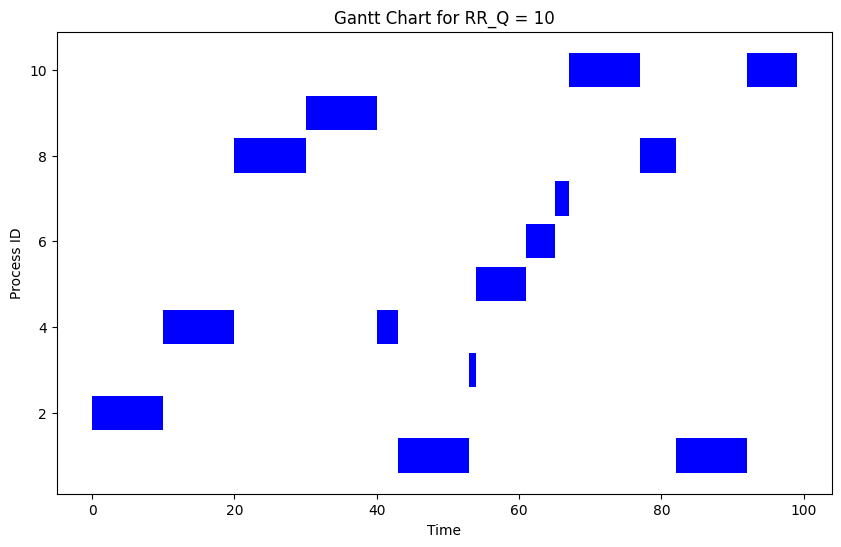

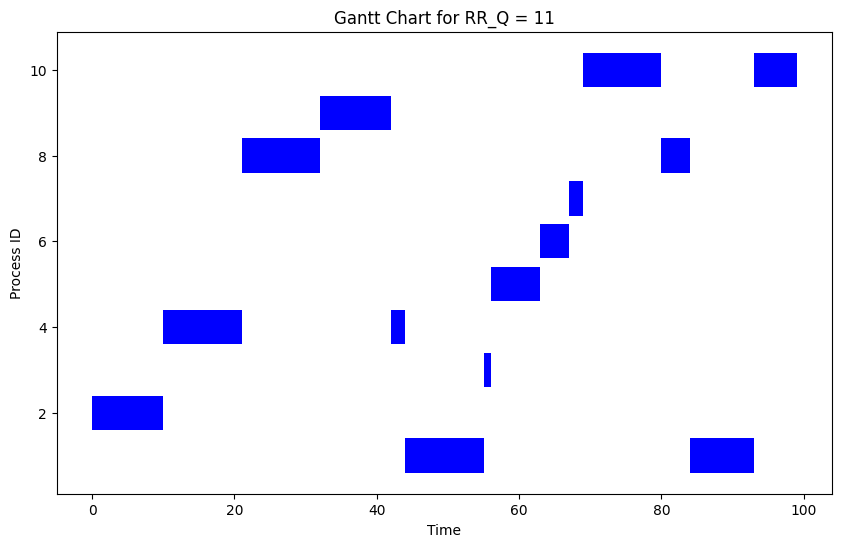

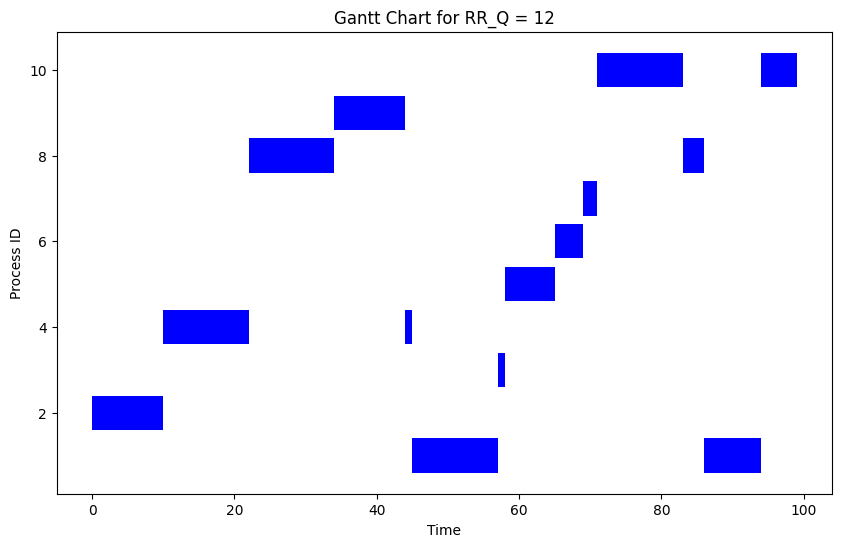

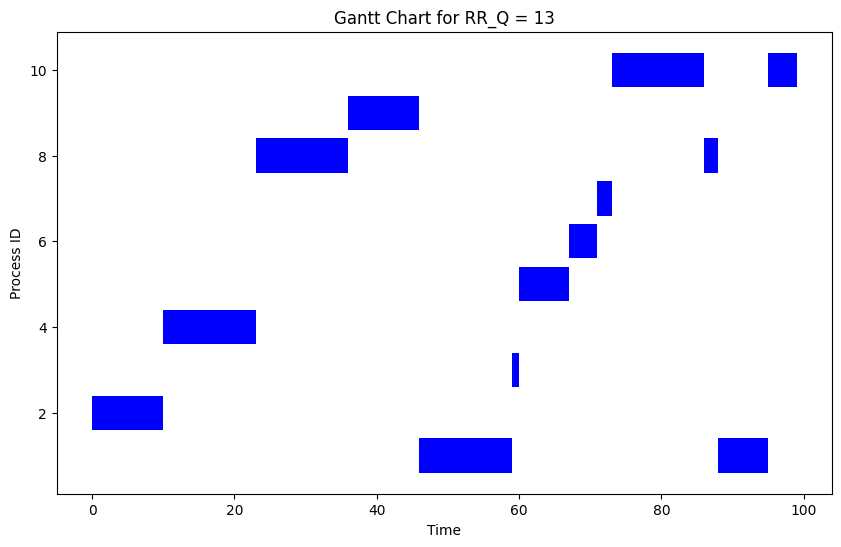

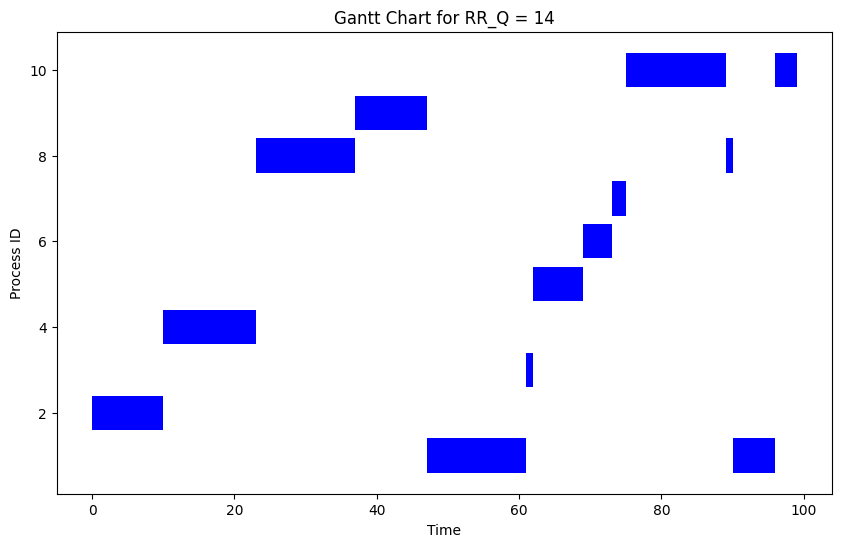

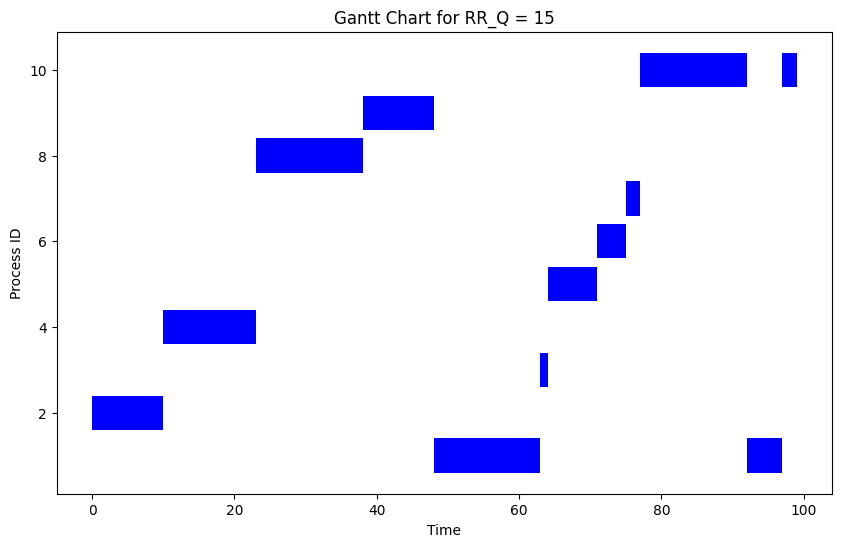

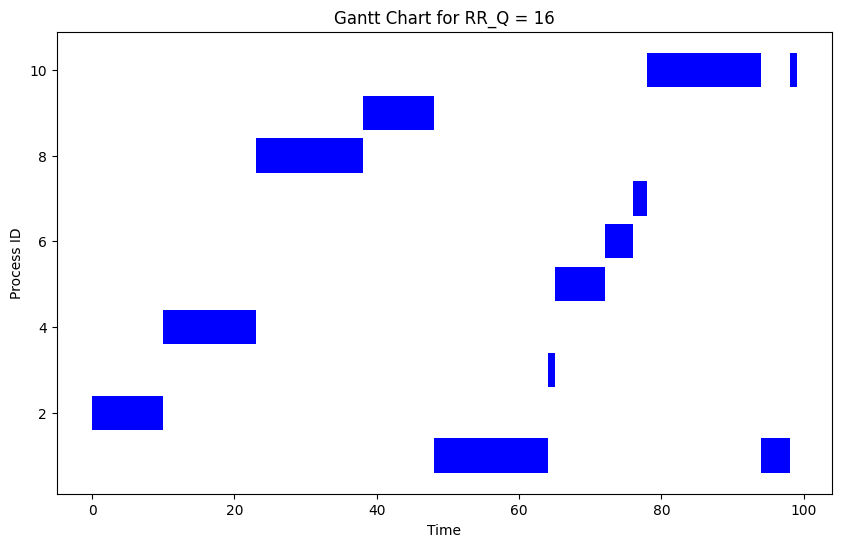

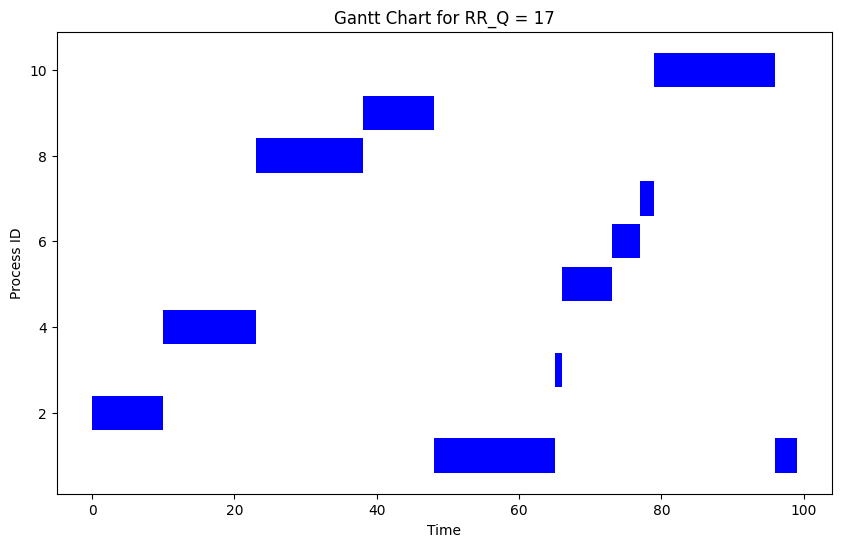

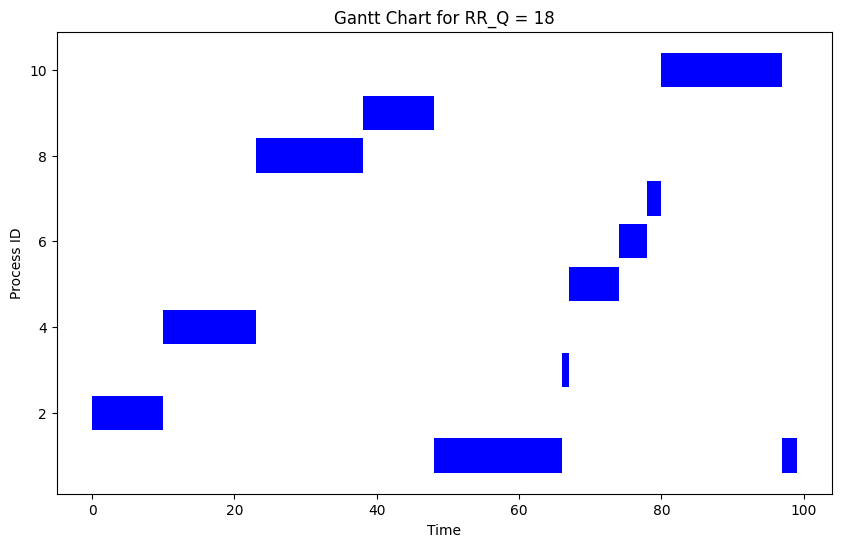

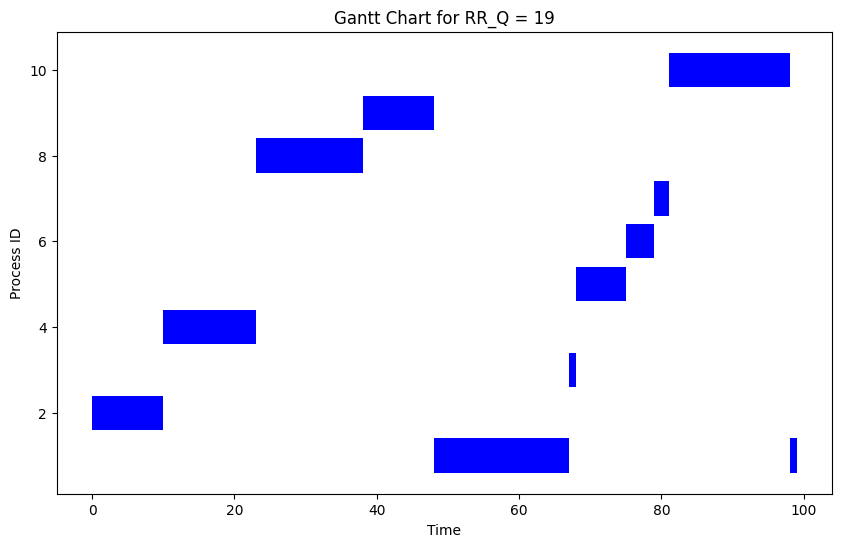

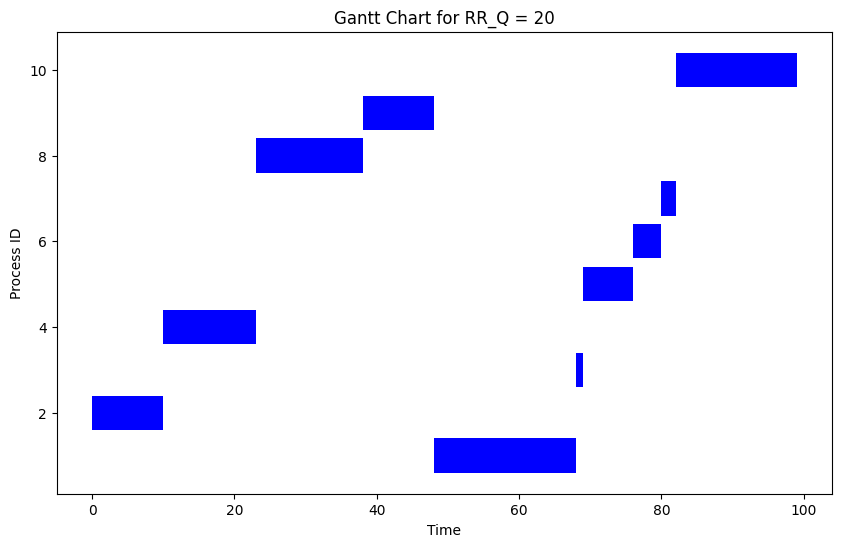

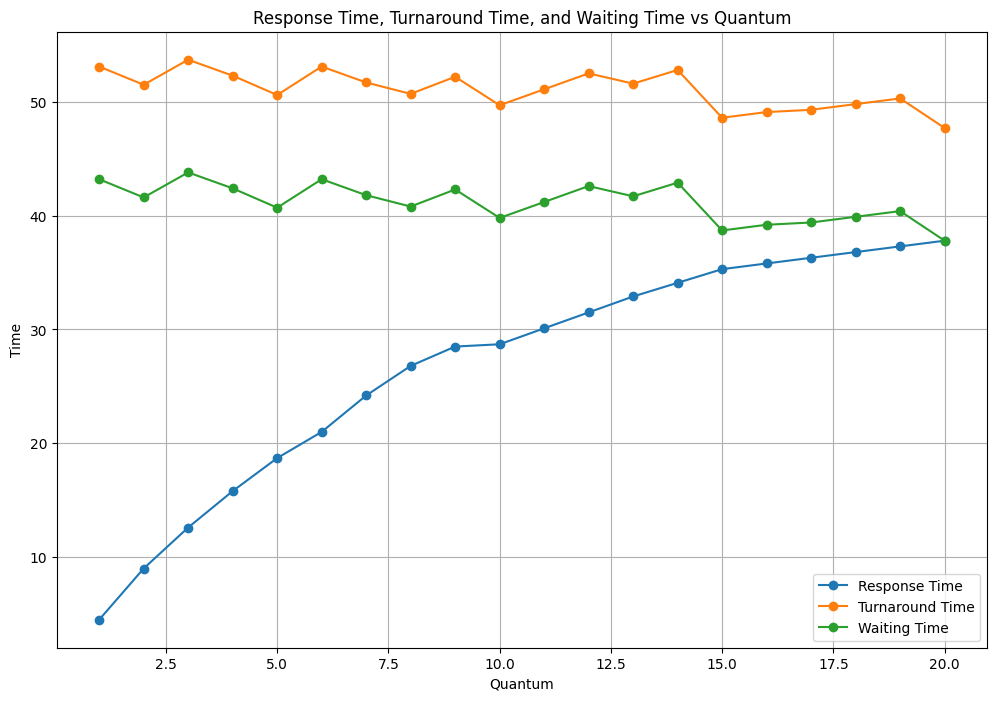

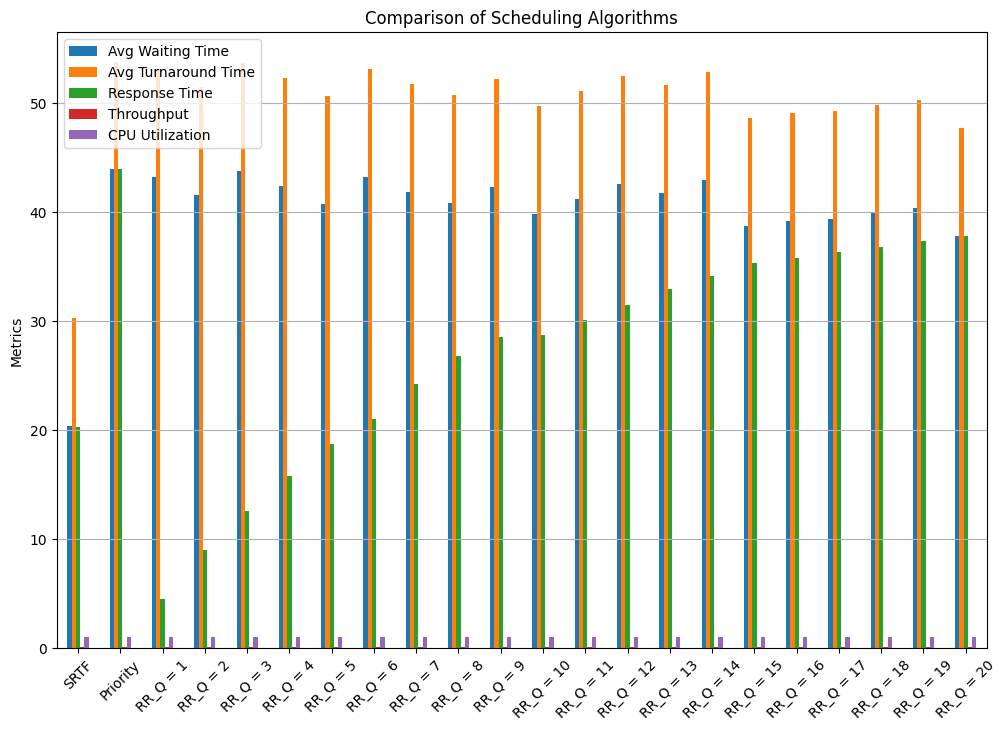

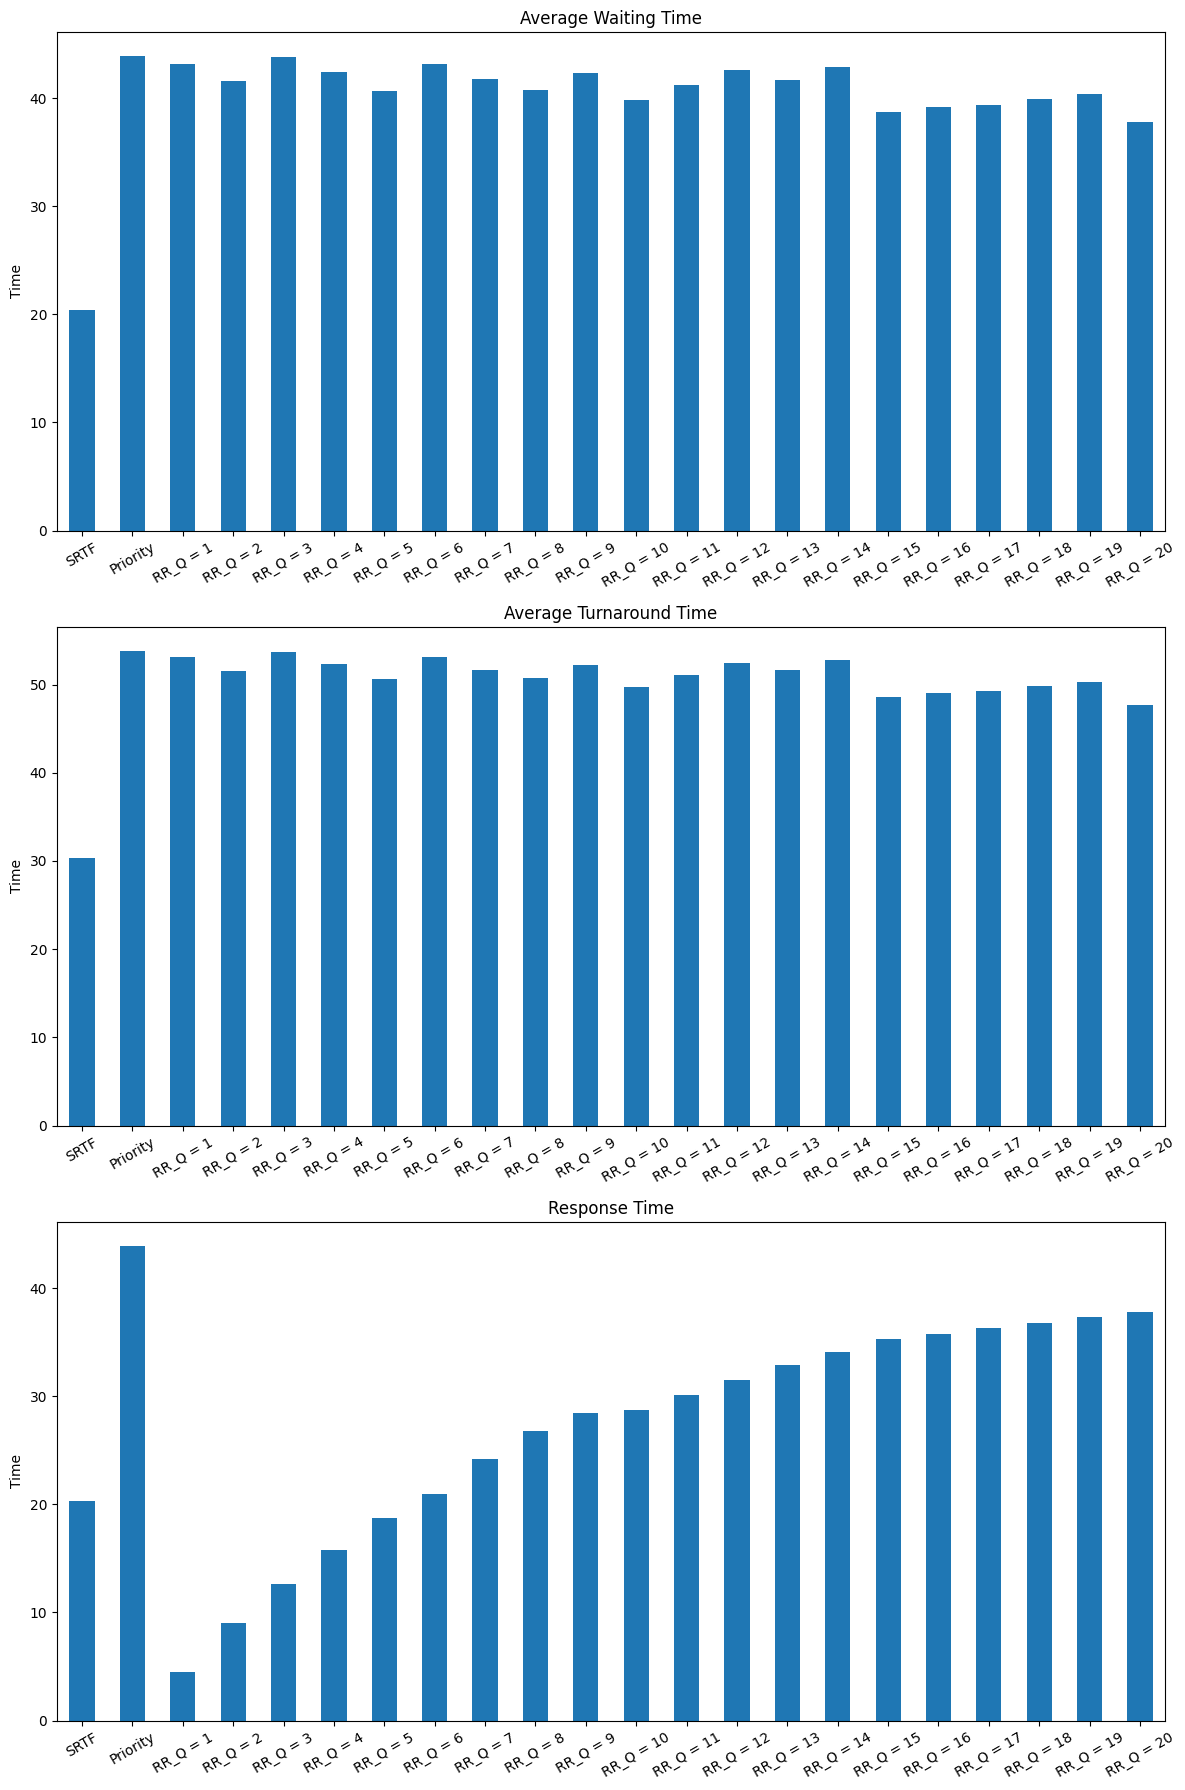

In [153]:
# 示例執行
processes = generate_random_processes(num_processes=10, max_arrival_time=20, max_burst_time=20, max_priority=10)

#顯示進程資訊
for p in processes:
    print(f"Process {p.pid}: Arrival Time={p.arrival_time}, Burst Time={p.burst_time}, Priority={p.priority}")

max_burst_time = 20# Round Robin 的時間量子
result_df = compare_scheduling_algorithms(processes, max_burst_time)
#最後結果輸出為CSV
result_df.to_csv('result.csv')